In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta

import seaborn as sns
import matplotlib.pyplot as plt

# additional settings
pd.options.display.float_format = '{:.3f}'.format

In [2]:
raw_df = pd.read_parquet('.\\raw_data\\yellow_tripdata_2021-12.parquet')

In [3]:
raw_df.shape

(3214369, 19)

In [4]:
raw_df = raw_df[(raw_df['tpep_dropoff_datetime'] <= '2021-12-26') & (raw_df['tpep_dropoff_datetime'] >= '2021-12-24')]

raw_df = raw_df[(raw_df['tpep_pickup_datetime'] >= '2021-12-24') & (raw_df['tpep_pickup_datetime'] <= '2021-12-26')]

In [5]:
raw_df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
2563086,2,2021-12-24 11:12:35,2021-12-24 11:39:14,1.000,10.890,1.000,N,138,48,1,33.000,1.000,0.500,9.020,6.550,0.300,54.120,2.500,1.250
2574898,2,2021-12-24 13:23:07,2021-12-24 13:44:31,1.000,8.960,1.000,N,138,230,1,27.500,1.000,0.500,9.900,6.550,0.300,49.500,2.500,1.250
2579451,2,2021-12-24 13:49:55,2021-12-24 13:57:44,1.000,1.070,1.000,N,161,237,1,7.000,0.500,0.500,1.700,0.000,0.300,12.500,2.500,0.000
2583063,2,2021-12-24 14:54:22,2021-12-24 15:13:16,1.000,8.790,1.000,N,138,238,2,26.500,0.500,0.500,0.000,6.550,0.300,35.600,0.000,1.250
2583064,2,2021-12-24 15:15:33,2021-12-24 15:34:51,1.000,3.460,1.000,N,238,186,2,15.000,0.500,0.500,0.000,0.000,0.300,18.800,2.500,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3205151,6,2021-12-25 23:12:17,2021-12-25 23:12:15,NaN,14.720,NaN,None,265,94,0,39.260,0.000,0.500,0.000,0.000,0.300,40.060,NaN,NaN
3205152,2,2021-12-25 23:01:00,2021-12-25 23:13:00,NaN,3.730,NaN,None,236,113,0,16.480,0.000,0.500,4.230,0.000,0.300,24.010,NaN,NaN
3205153,2,2021-12-25 23:52:00,2021-12-26 00:00:00,NaN,2.540,NaN,None,114,170,0,13.200,0.000,0.500,3.500,0.000,0.300,20.000,NaN,NaN
3205154,1,2021-12-25 23:48:12,2021-12-25 23:49:03,NaN,0.300,NaN,None,140,140,0,3.000,0.500,0.500,1.020,0.000,0.300,7.820,NaN,NaN


## Missing value and Outlier engineering.

### Categorical and Datetime columns

#### Vendor ID
A code indicating the TPEP (Taxicab Technology Service Provider) that provided the record. 
1. Creative Mobile Technologies, LLC
2. VeriFone Inc.

others can be treated as an outlier.

In [6]:
raw_df['VendorID'].value_counts(dropna=False)

2    78497
1    31434
6      200
Name: VendorID, dtype: int64

In [7]:
# removing outliers
raw_df = raw_df[(raw_df['VendorID'] == 1) | (raw_df['VendorID'] == 2)]

#### Pickup and drop off datetime
defines when the ride stared and ended. These columns will be used to create target variable - trip_duration.

In [8]:
raw_df.tpep_pickup_datetime.describe(datetime_is_numeric=True)

count                           109931
mean     2021-12-24 23:35:18.381211904
min                2021-12-24 00:00:03
25%         2021-12-24 13:47:09.500000
50%                2021-12-24 18:58:26
75%         2021-12-25 12:46:18.500000
max                2021-12-25 23:58:57
Name: tpep_pickup_datetime, dtype: object

In [9]:
raw_df.tpep_dropoff_datetime.describe(datetime_is_numeric=True)

count                           109931
mean     2021-12-24 23:49:17.031237632
min                2021-12-24 00:02:29
25%         2021-12-24 13:59:45.500000
50%                2021-12-24 19:12:18
75%         2021-12-25 12:59:56.500000
max                2021-12-26 00:00:00
Name: tpep_dropoff_datetime, dtype: object

As we can see the min/max are outliers, anyways as we are interested only in Crhistmas period, we will leave values only for 24th 25th and 26th of december. also I will follow these **assumptions** for data cleaning:
- trips must start at 24th of december 00:00:00
- trips, that starts at the last day of the month, might end within first hour of the following month.


In [10]:
# current solution to iterate if datasets changes
files_in_folder = os.listdir("./raw_data")

date = [i.split('_')[-1].split('.')[0] for i in files_in_folder]

In [11]:
date

['2017-12', '2018-12', '2019-12', '2020-12', '2021-12']

In [12]:
def get_beginning_date(year_of_dataset:str = '2021-12'):
    start_month = dt.strptime(year_of_dataset,'%Y-%m')
    return start_month
beginning_of_month = get_beginning_date()

beginning_of_month

datetime.datetime(2021, 12, 1, 0, 0)

In [13]:
end_of_month = beginning_of_month + relativedelta(months=1)
end_of_month

datetime.datetime(2022, 1, 1, 0, 0)

In [14]:
end_of_month_for_drop_off = end_of_month + relativedelta(hours=1)
end_of_month_for_drop_off

datetime.datetime(2022, 1, 1, 1, 0)

In [15]:
# restrictions for pickup time
raw_df = raw_df[
    (raw_df['tpep_pickup_datetime'] >= beginning_of_month
) &(
    raw_df['tpep_pickup_datetime'] < end_of_month)
    ]

In [16]:
raw_df = raw_df[
    (raw_df['tpep_dropoff_datetime'] >= beginning_of_month
) &(
    raw_df['tpep_dropoff_datetime'] < end_of_month_for_drop_off)
    ]

In [17]:
raw_df.tpep_pickup_datetime.describe(datetime_is_numeric=True)

count                           109931
mean     2021-12-24 23:35:18.381211904
min                2021-12-24 00:00:03
25%         2021-12-24 13:47:09.500000
50%                2021-12-24 18:58:26
75%         2021-12-25 12:46:18.500000
max                2021-12-25 23:58:57
Name: tpep_pickup_datetime, dtype: object

In [18]:
raw_df.tpep_dropoff_datetime.describe(datetime_is_numeric=True)

count                           109931
mean     2021-12-24 23:49:17.031237632
min                2021-12-24 00:02:29
25%         2021-12-24 13:59:45.500000
50%                2021-12-24 19:12:18
75%         2021-12-25 12:59:56.500000
max                2021-12-26 00:00:00
Name: tpep_dropoff_datetime, dtype: object

#### Trip Duration
This is an aggregated colum and a Target variable for the model.

**Trip duration will be calculated in minutes.**

after the target variable will be created dropoff datetime column will be removed.

As target column is continuous it will be analyzed together with other continous columns.

In [19]:
raw_df['trip_duration_minutes'] = ((raw_df.tpep_dropoff_datetime - raw_df.tpep_pickup_datetime).dt.total_seconds()) / 60

#### Passenger count

The maximum amount of passengers allowed in a yellow taxicab by law is four (4)
in a four (4) passenger taxicab or five (5) passengers in a five (5) passenger taxicab,
except that an additional passenger must be accepted if such passenger is under the age of seven (7) and is held on the lap of an adult passenger seated in the rear.


In [20]:
raw_df.passenger_count.value_counts( dropna=False)

1.000    72333
2.000    18388
3.000     6286
NaN       3499
4.000     3235
5.000     2623
0.000     2221
6.000     1345
8.000        1
Name: passenger_count, dtype: int64

**Assumption**: 
- restricting to 6 people,4 adults 2 kids as maximum number of passengers in the car
- n/a values will be imputed using mode (as using dataframe filters would remove data from dataset)
- 0 passengers are allowed as it might be used to deliver gifts :)

In [21]:
raw_df.passenger_count.value_counts(normalize=True,dropna=False)

1.000   0.658
2.000   0.167
3.000   0.057
NaN     0.032
4.000   0.029
5.000   0.024
0.000   0.020
6.000   0.012
8.000   0.000
Name: passenger_count, dtype: float64

In [22]:
passenger_count_mode_value = raw_df['passenger_count'].mode()
raw_df['passenger_count'].fillna(float(passenger_count_mode_value), inplace=True)

In [23]:
raw_df.passenger_count.value_counts(normalize=True,dropna=False)

1.000   0.690
2.000   0.167
3.000   0.057
4.000   0.029
5.000   0.024
0.000   0.020
6.000   0.012
8.000   0.000
Name: passenger_count, dtype: float64

#### RatecodeID
The final rate code in effect at the end of the trip. identifies location and the size of the fare, yet holds no information in relation to the duration
1. Standard rate
2. JFK
3. Newark
4. Nassau or Westchester
5. Negotiated fare
6. Group ride

In [24]:

raw_df.RatecodeID.value_counts(normalize=True,dropna=False)

1.000    0.918
2.000    0.036
NaN      0.032
5.000    0.008
3.000    0.004
4.000    0.001
99.000   0.001
6.000    0.000
Name: RatecodeID, dtype: float64

as we can see this categorical value is extremely inbalanced.

**asumptions**:
- will inpute with mode value of the column
- will select only the records with standard rate and airports (JFK, Newark)

In [25]:
ratecode_id_mode_value = raw_df['RatecodeID'].mode()
raw_df['RatecodeID'].fillna(float(ratecode_id_mode_value), inplace=True)


In [26]:
raw_df.RatecodeID.value_counts(normalize=True,dropna=False)

1.000    0.950
2.000    0.036
5.000    0.008
3.000    0.004
4.000    0.001
99.000   0.001
6.000    0.000
Name: RatecodeID, dtype: float64

In [27]:
raw_df = raw_df[(raw_df['RatecodeID']== 1) | (raw_df['RatecodeID']== 2) | (raw_df['RatecodeID']== 3)]

#### Store and forward flag
This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.

Y= store and forward trip  
N= not a store and forward trip

In [28]:
raw_df['store_and_fwd_flag'].value_counts(normalize=True,dropna=False)

N      0.947
None   0.032
Y      0.021
Name: store_and_fwd_flag, dtype: float64

**Assumptions**:
- i will treat *None* values as store and forward, assuming that if there were no issues with the memory - it would not be stored.

In [29]:
raw_df['store_and_fwd_flag'].fillna('Y', inplace=True)

In [30]:
raw_df['store_and_fwd_flag'].value_counts(normalize=True,dropna=False)

N   0.947
Y   0.053
Name: store_and_fwd_flag, dtype: float64

#### Payment type

A numeric code signifying how the passenger paid for the trip.  
    1= Credit card  
    2= Cash  
    3= No charge  
    4= Dispute  
    5= Unknown  
    6= Voided trip  

In [31]:
raw_df['payment_type'].value_counts(normalize=True,dropna=False)

1   0.649
2   0.306
0   0.032
3   0.007
4   0.006
Name: payment_type, dtype: float64

**assumptions**:
- 0 values will be treated as corrupt data.
- for this excercise i will include only trips that are paid by cash(2) or by Credit card(1) as they correspond to 96% of all values.

In [32]:
# raw_df[raw_df.loc[:,'payment_type'] ==0] = 1

In [33]:
raw_df = raw_df[(raw_df['payment_type']==1) | (raw_df['payment_type'] ==2)]

In [34]:
raw_df['payment_type'].value_counts(normalize=True,dropna=False)

1   0.679
2   0.321
Name: payment_type, dtype: float64

#### MTA_tax
$0.50 MTA tax that is automatically triggered based on the metered
rate in use.

In [35]:
raw_df['mta_tax'].value_counts(normalize=True,dropna=False)

0.500    0.994
0.000    0.005
-0.500   0.001
Name: mta_tax, dtype: float64

**Asumption**:
- As per description i will leave only records that are 0.5$ as it correspond to 99.8 percent of all records. other records will be treated as an outlier
- This record is applied to all rides, it will be *removed from the dataset*

#### Improvement_surcharge
$0.30 improvement surcharge assessed trips at the flag drop. The
improvement surcharge began being levied in 2015.

In [36]:
raw_df['improvement_surcharge'].value_counts(normalize=True,dropna=False)


0.300    0.999
-0.300   0.001
0.000    0.000
Name: improvement_surcharge, dtype: float64

In [37]:
# raw_df = raw_df[raw_df['improvement_surcharge'] == 0.3]

# raw_df['improvement_surcharge'].value_counts(normalize=True,dropna=False)

**Assumption**:
- as per description the improvement surcharge should be equal to 0.3$, i will treat other values as an outlier.
- This record is applied to all rides, it will be *removed from the dataset*

#### Congestion surcharge
Total amount collected in trip for NYS congestion surcharge.
* $2.50 per trip when the transportation is provided by a medallion taxicab vehicle.

In [38]:
raw_df['congestion_surcharge'].value_counts(normalize=True,dropna=False)

2.500    0.914
0.000    0.085
-2.500   0.001
Name: congestion_surcharge, dtype: float64

**Assumptions**:
* only 2.5$ and 0$ will be left
* column will be transformed to boolean value 1 if has congestion surcharge and 0 if does not.

In [39]:
raw_df = raw_df[(raw_df['congestion_surcharge'] == 0) | (raw_df['congestion_surcharge'] == 2.5)]

In [40]:
raw_df['congestion_surcharge'].value_counts(normalize=True,dropna=False)

2.500   0.915
0.000   0.085
Name: congestion_surcharge, dtype: float64

In [41]:
raw_df['congestion_surcharge'] = raw_df['congestion_surcharge'].replace(2.5, 1)

In [42]:
raw_df['congestion_surcharge'].value_counts(normalize=True,dropna=False)

1.000   0.915
0.000   0.085
Name: congestion_surcharge, dtype: float64

#### Airport Fee
$1.25 for pick up only at LaGuardia and John F. Kennedy Airports

In [43]:
raw_df['airport_fee'].value_counts(normalize=True,dropna=False)

0.000    0.930
1.250    0.070
-1.250   0.000
Name: airport_fee, dtype: float64

**Assumptions**:
- only values containig 1.25$ and 0$
* column will be transformed to boolean value 1 if has airport fee and 0 if does not.

In [44]:
raw_df = raw_df[(raw_df['airport_fee'] == 0) | (raw_df['airport_fee'] == 1.25)]
raw_df['airport_fee'] = raw_df['airport_fee'].replace(1.25, 1)

In [45]:
raw_df['airport_fee'].value_counts(normalize=True,dropna=False)

0.000   0.930
1.000   0.070
Name: airport_fee, dtype: float64

#### Pickup Location
TLC Taxi Zone in which the taximeter was engaged.

From taxi zone lookup table, which could be found here, we can see if threre are any values, with unknown locations. if so - these values will be removed

source: [taxi_zone_lookup_table](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

In [46]:
raw_df['PULocationID'].isna().sum()

0

In [47]:
raw_df = raw_df[(raw_df['PULocationID'] != 264) | (raw_df['PULocationID'] != 265)]

#### Drop off Location
TLC Taxi Zone in which the taximeter was disengaged

From taxi zone lookup table, which could be found here, we can see if threre are any values, with unknown locations. if so - these values will be removed

source: [taxi_zone_lookup_table](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

In [48]:
raw_df['DOLocationID'].isna().sum()

0

In [49]:
raw_df = raw_df[(raw_df['DOLocationID'] != 264) | (raw_df['DOLocationID'] != 265)]

### Continous columns

In [50]:
continous_columns = ['trip_distance','fare_amount','tip_amount','tolls_amount','total_amount','trip_duration_minutes','extra']

In [51]:
# raw_df = raw_df[continous_columns].copy()
# raw_df.shape

In [52]:
raw_df.sample(10, random_state=1)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration_minutes
2687994,2,2021-12-25 18:16:05,2021-12-25 18:47:53,1.000,4.200,1.000,N,43,79,1,22.000,0.000,0.500,0.550,0.000,0.300,25.850,1.000,0.000,31.800
2657017,2,2021-12-24 23:55:26,2021-12-25 00:00:07,3.000,0.740,1.000,N,79,114,2,5.000,0.500,0.500,0.000,0.000,0.300,8.800,1.000,0.000,4.683
2681625,1,2021-12-25 16:27:29,2021-12-25 16:42:59,2.000,1.000,1.000,N,234,161,1,10.500,2.500,0.500,2.000,0.000,0.300,15.800,1.000,0.000,15.500
2608976,2,2021-12-24 11:52:02,2021-12-24 12:18:25,1.000,14.340,1.000,N,138,259,2,39.000,0.000,0.500,0.000,6.550,0.300,46.350,0.000,1.000,26.383
2693563,1,2021-12-25 21:31:18,2021-12-25 21:47:26,1.000,3.000,1.000,N,170,148,2,13.500,3.000,0.500,0.000,0.000,0.300,17.300,1.000,0.000,16.133
2663002,2,2021-12-25 07:40:36,2021-12-25 07:54:59,2.000,3.260,1.000,N,186,140,1,13.000,0.000,0.500,0.000,0.000,0.300,16.300,1.000,0.000,14.383
2625437,2,2021-12-24 15:17:22,2021-12-24 15:28:07,1.000,1.600,1.000,N,236,43,1,9.000,0.000,0.500,2.460,0.000,0.300,14.760,1.000,0.000,10.750
2686873,2,2021-12-25 18:16:46,2021-12-25 18:20:12,6.000,0.790,1.000,N,151,238,2,4.500,0.000,0.500,0.000,0.000,0.300,7.800,1.000,0.000,3.433
2615679,1,2021-12-24 13:58:16,2021-12-24 14:04:06,3.000,1.300,1.000,N,68,234,2,6.500,2.500,0.500,0.000,0.000,0.300,9.800,1.000,0.000,5.833
2632666,2,2021-12-24 16:18:19,2021-12-24 16:24:13,1.000,0.930,1.000,N,141,237,2,6.000,0.000,0.500,0.000,0.000,0.300,9.300,1.000,0.000,5.900


#### Trip Duration Minutes

In [53]:
raw_df['trip_duration_minutes'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.99,0.995,0.997, 0.999])

count   103844.000
mean        13.815
std         47.123
min          0.000
10%          3.733
25%          5.917
50%          9.767
75%         15.804
90%         24.133
99%         44.583
99.5%       51.563
99.7%       58.915
99.9%     1295.808
max       1439.250
Name: trip_duration_minutes, dtype: float64

In [54]:
raw_df = raw_df[(raw_df['trip_duration_minutes'] <= np.quantile(raw_df['trip_duration_minutes'],0.995)) & (raw_df['trip_duration_minutes'] > 0)]


In [55]:
raw_df.shape

(103299, 20)

In [56]:
raw_df['trip_duration_minutes'].describe()

count   103299.000
mean        11.999
std          8.478
min          0.033
25%          5.900
50%          9.717
75%         15.667
max         51.550
Name: trip_duration_minutes, dtype: float64

In [57]:
# sns.boxplot(raw_df['trip_duration_minutes'])

<Axes: xlabel='trip_duration_minutes', ylabel='Count'>

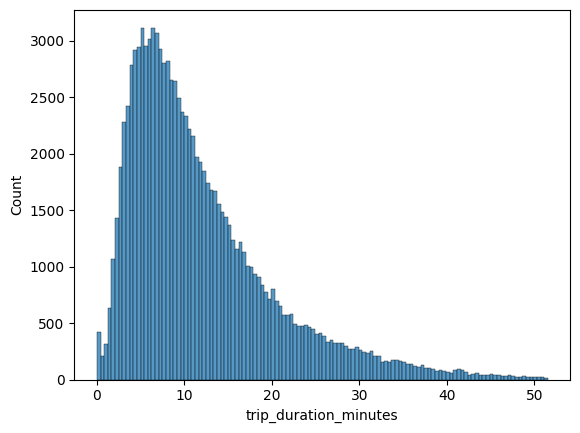

In [58]:
sns.histplot(raw_df['trip_duration_minutes'])

#### Trip Distance
The elapsed trip distance in miles reported by the taximeter.

In [59]:
raw_df['trip_distance'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.995, 0.999])

count   103299.000
mean         3.345
std          4.396
min          0.000
10%          0.700
25%          1.080
50%          1.800
75%          3.410
90%          8.330
99%         19.600
99.5%       20.850
99.9%       24.570
max        359.300
Name: trip_distance, dtype: float64

In [60]:
# limiting trip distance to 95th percentile to filter out outliers
raw_df = raw_df[(raw_df['trip_distance'] < np.quantile(raw_df['trip_distance'],0.995)) & (raw_df['trip_distance'] > 0)]


In [61]:
# sns.boxplot(raw_df['trip_distance'])

<Axes: xlabel='trip_distance', ylabel='Count'>

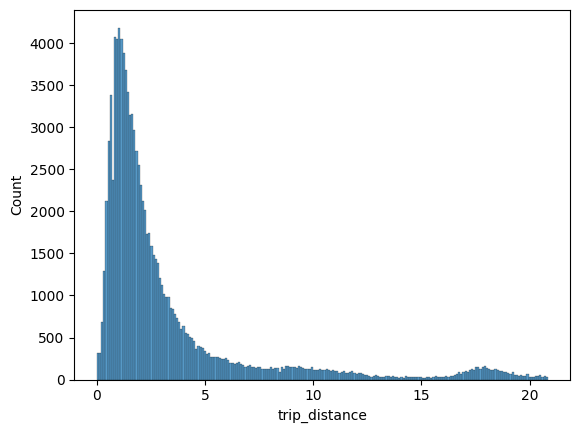

In [62]:
sns.histplot(raw_df['trip_distance'])

<Axes: xlabel='trip_duration_minutes', ylabel='trip_distance'>

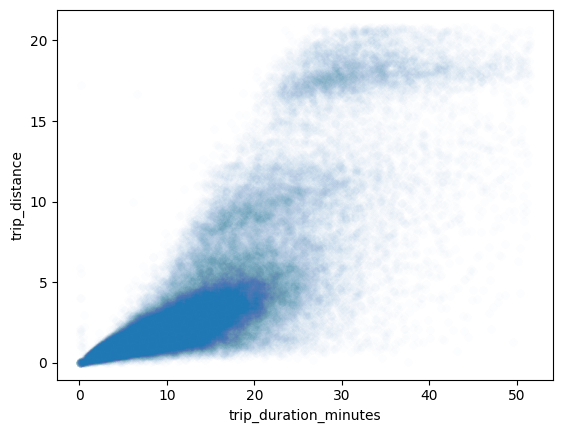

In [63]:
sns.scatterplot( x=raw_df['trip_duration_minutes'], y=raw_df['trip_distance'],alpha=0.01)

<Axes: xlabel='trip_distance', ylabel='Count'>

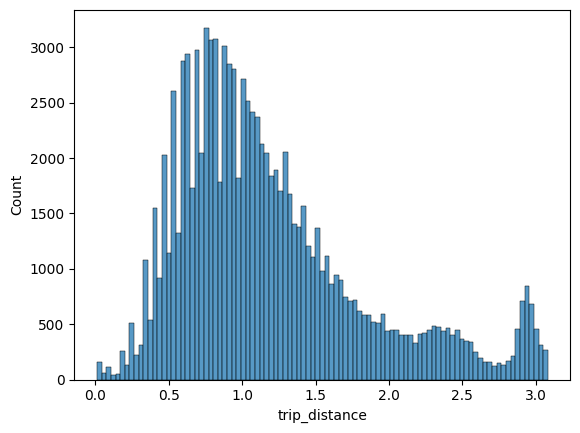

In [64]:
sns.histplot(np.log1p(raw_df['trip_distance']))

<Axes: xlabel='trip_duration_minutes', ylabel='trip_distance'>

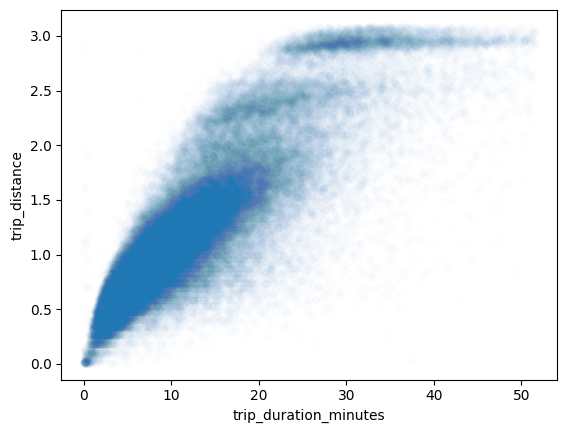

In [65]:
sns.scatterplot( x=raw_df['trip_duration_minutes'], y=np.log1p(raw_df['trip_distance']),alpha=0.01)

In [66]:
# raw_df['log1p_trip_distance'] = np.log1p(raw_df['trip_distance'])

#### Fare Amount

The time-and-distance fare calculated by the meter.  
This column will be removed as it would cause data leakage, as it is derived by time and distance.

it will only be used to remove outliers

In [67]:
raw_df['fare_amount'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.995, 0.999])

count   102108.000
mean        12.711
std         14.390
min        -52.000
10%          5.000
25%          6.500
50%          9.000
75%         14.000
90%         25.500
99%         52.000
99.5%       52.000
99.9%       66.500
max       3009.000
Name: fare_amount, dtype: float64

<Axes: xlabel='fare_amount', ylabel='Count'>

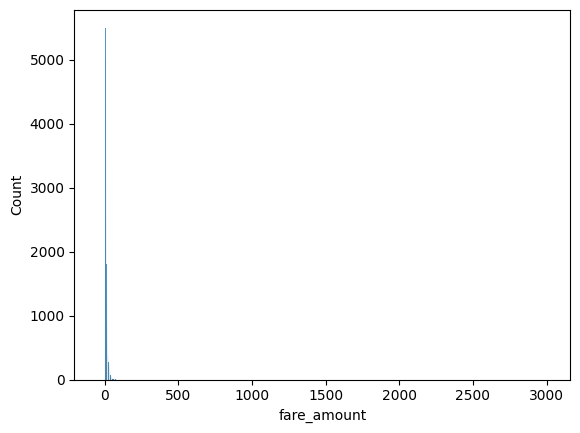

In [68]:
sns.histplot(raw_df['fare_amount'])

<Axes: xlabel='trip_duration_minutes', ylabel='fare_amount'>

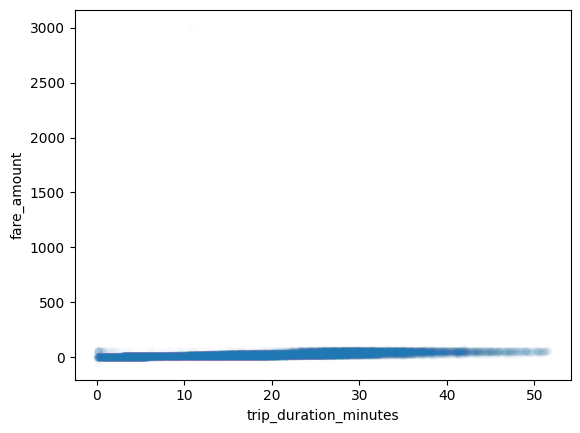

In [69]:
sns.scatterplot( x=raw_df['trip_duration_minutes'], y=raw_df['fare_amount'],alpha=0.01)

In [70]:
raw_df = raw_df[(raw_df['fare_amount'] > 0) & (raw_df['fare_amount'] <= np.quantile(raw_df['fare_amount'],0.99))]

<Axes: xlabel='fare_amount', ylabel='Count'>

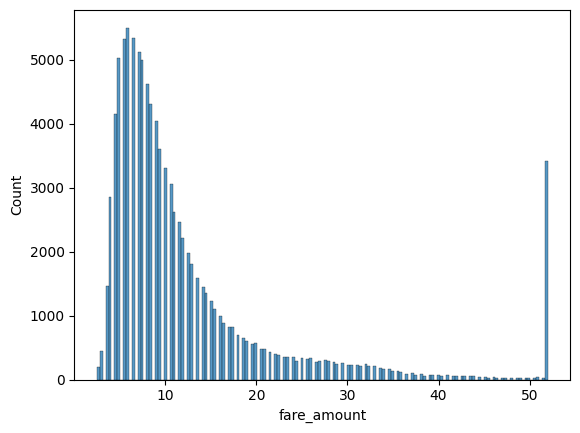

In [71]:
sns.histplot(raw_df['fare_amount'])

<Axes: xlabel='trip_duration_minutes', ylabel='fare_amount'>

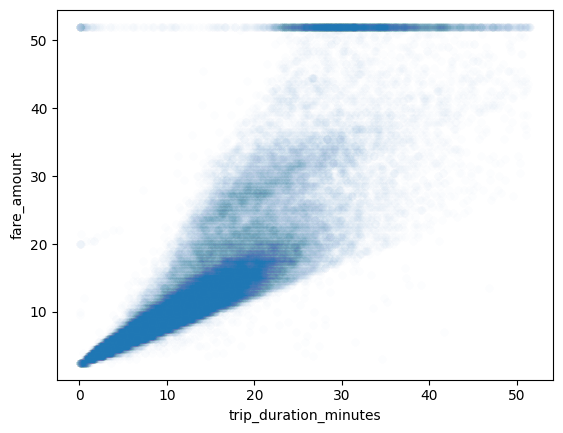

In [72]:
sns.scatterplot( x=raw_df['trip_duration_minutes'], y=raw_df['fare_amount'],alpha=0.01)

**Assumptions**:
- fare amount can not be negative
- fare amount is capped at 99th percentile, treating remaining 1% as outliers

#### Tip Amount
Tip amount – This field is automatically populated for credit card tips. Cash tips are not included.

In [73]:
raw_df['tip_amount'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.995, 0.999])

count   101649.000
mean         2.161
std          2.755
min          0.000
10%          0.000
25%          0.000
50%          1.860
75%          2.960
90%          4.860
99%         12.600
99.5%       14.800
99.9%       20.000
max        100.000
Name: tip_amount, dtype: float64

In [74]:
raw_df = raw_df[raw_df['tip_amount'] <= np.quantile(raw_df['tip_amount'],0.999)]

<Axes: xlabel='tip_amount', ylabel='Count'>

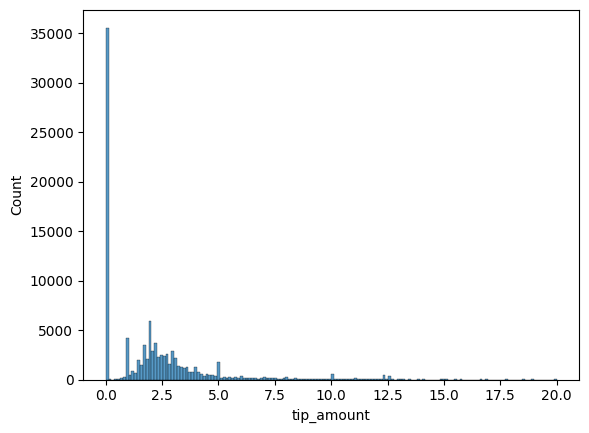

In [75]:
sns.histplot(raw_df['tip_amount'])

<Axes: xlabel='trip_duration_minutes', ylabel='tip_amount'>

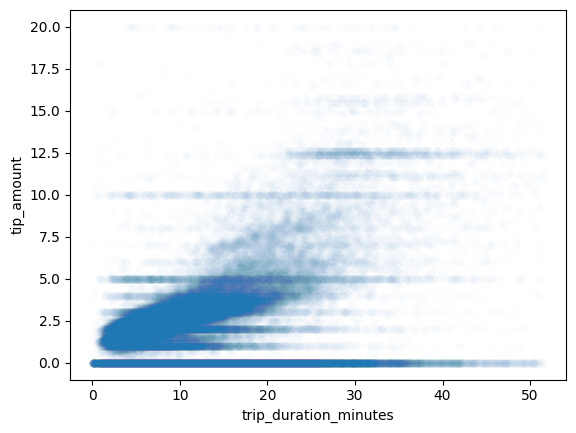

In [76]:
sns.scatterplot( x=raw_df['trip_duration_minutes'], y=raw_df['tip_amount'],alpha=0.01)

<Axes: xlabel='tip_amount'>

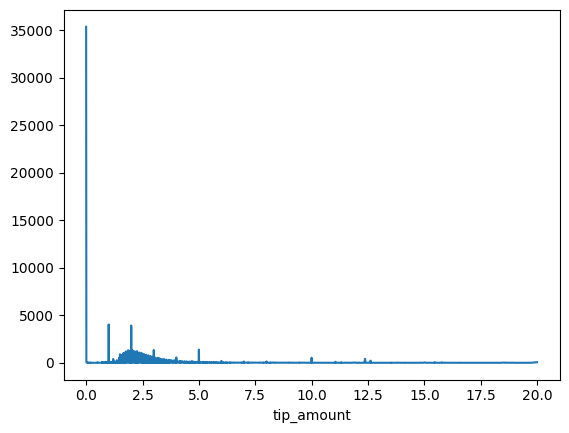

In [77]:
raw_df.groupby('tip_amount').count()['trip_duration_minutes'].plot()

In [78]:
raw_df['tip_percent'] = round(raw_df['tip_amount'] / raw_df['total_amount'],3)

In [79]:
(raw_df.groupby('tip_percent').count()['trip_duration_minutes']).sort_values(ascending=False)

tip_percent
0.000    35379
0.167    23938
0.166     7542
0.200     7330
0.231     4317
         ...  
0.232        1
0.418        1
0.416        1
0.415        1
0.707        1
Name: trip_duration_minutes, Length: 483, dtype: int64

<Axes: xlabel='tip_percent'>

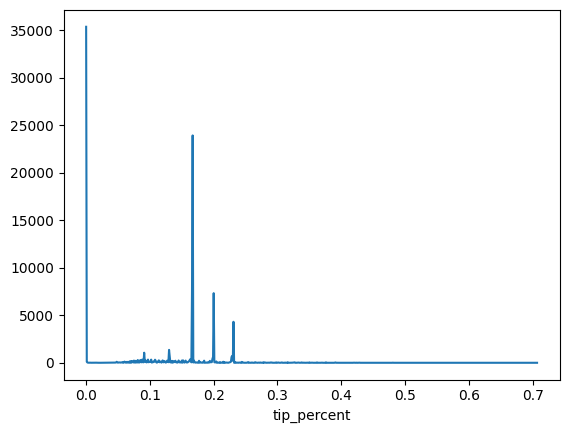

In [80]:
raw_df.groupby('tip_percent').count()['trip_duration_minutes'].plot()

**assumptions**:
- as tips highly depend on fare amount, hence total amount (including all fees), i will remove tips column from dataset to prevent data leakage in first MVP

#### Tolls amount
Total amount of all tolls paid in trip.

In [88]:
raw_df['tolls_amount'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.995, 0.999])

count   101583.000
mean         0.384
std          1.548
min          0.000
10%          0.000
25%          0.000
50%          0.000
75%          0.000
90%          0.000
99%          6.550
99.5%        6.550
99.9%        6.550
max         18.300
Name: tolls_amount, dtype: float64

<Axes: xlabel='tolls_amount', ylabel='Count'>

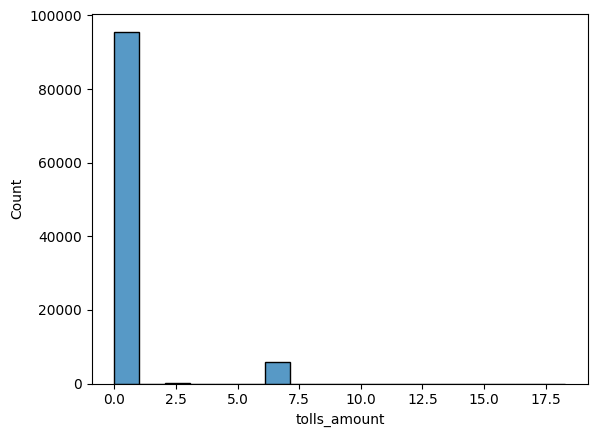

In [89]:
sns.histplot(raw_df['tolls_amount'])

In [90]:
raw_df = raw_df[raw_df['tolls_amount'] <= np.quantile(raw_df['tolls_amount'],0.99)]

<Axes: xlabel='tolls_amount', ylabel='Count'>

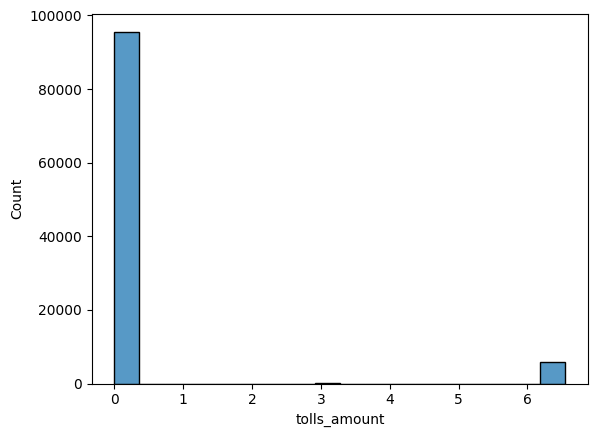

In [91]:
sns.histplot(raw_df['tolls_amount'])

<Axes: xlabel='trip_duration_minutes', ylabel='tolls_amount'>

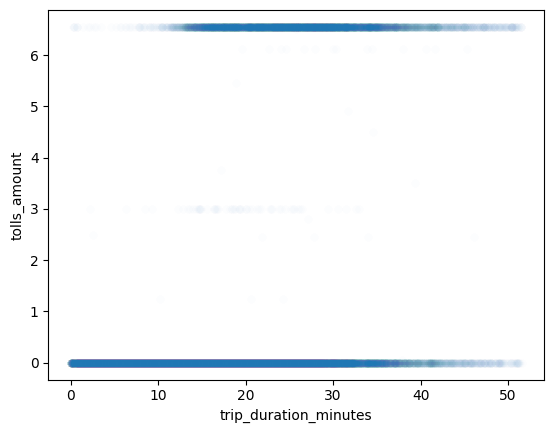

In [92]:
sns.scatterplot( x=raw_df['trip_duration_minutes'], y=raw_df['tolls_amount'],alpha=0.01)

**Assumption**:
- as there are no linear relationship between tolls amount and trip duration, i will create boolean column to identify if there were any tolls paid during the trip.

In [83]:
# raw_df['tolls_amount'] = raw_df.loc[:,'tolls_amount'].where(raw_df['tolls_amount'] > 0, 1)

raw_df.loc[raw_df.tolls_amount > 0, "tolls_amount"] = 1


In [84]:
raw_df.tolls_amount.value_counts()

0.000    95628
1.000     5955
Name: tolls_amount, dtype: int64

#### Total Amount

The total amount charged to passengers. Does not include cash tips.

as this column is based fare_amount, which is calculated by distance and duration of a trip, i will remove it. yet it will be used to remove outliers from the dataset.

In [94]:
raw_df['total_amount'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.995, 0.999])

count   101519.000
mean        18.317
std         13.104
min          3.300
10%          8.970
25%         10.800
50%         14.140
75%         19.560
90%         32.800
99%         74.220
99.5%       75.720
99.9%       79.127
max         84.500
Name: total_amount, dtype: float64

C:\Users\G026361\AppData\Local\Temp\ipykernel_13040\977638670.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(raw_df['total_amount'])


<Axes: xlabel='total_amount', ylabel='Density'>

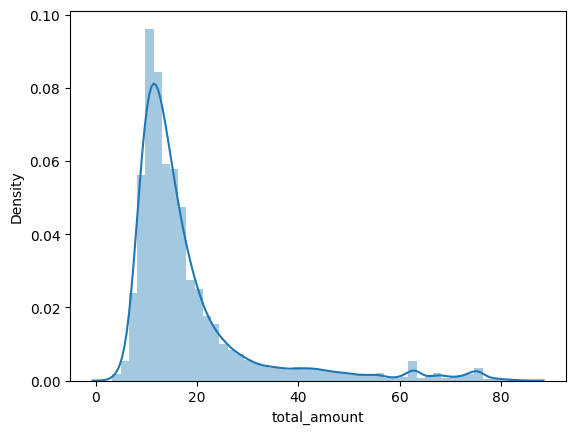

In [95]:
sns.distplot(raw_df['total_amount'])

<Axes: xlabel='trip_duration_minutes', ylabel='total_amount'>

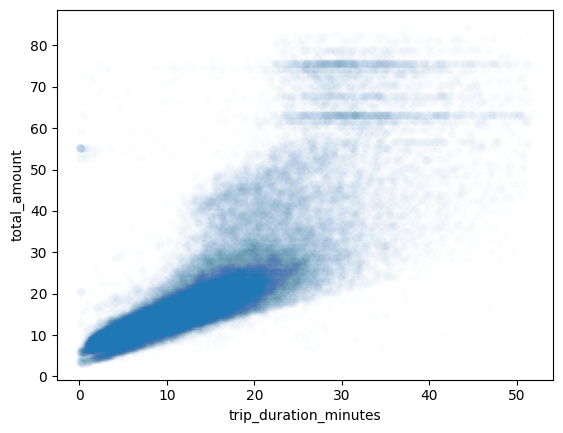

In [96]:
sns.scatterplot( x=raw_df['trip_duration_minutes'], y=raw_df['total_amount'],alpha=0.01)

C:\Users\G026361\AppData\Local\Temp\ipykernel_13040\4228441030.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(raw_df['total_amount']))


<Axes: xlabel='total_amount', ylabel='Density'>

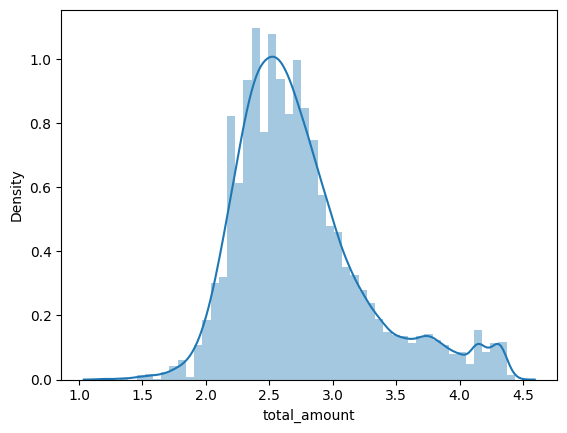

In [97]:
sns.distplot(np.log(raw_df['total_amount']))

C:\Users\G026361\AppData\Local\Temp\ipykernel_13040\427441234.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(round(raw_df.corr(),2),annot=True)


<Axes: >

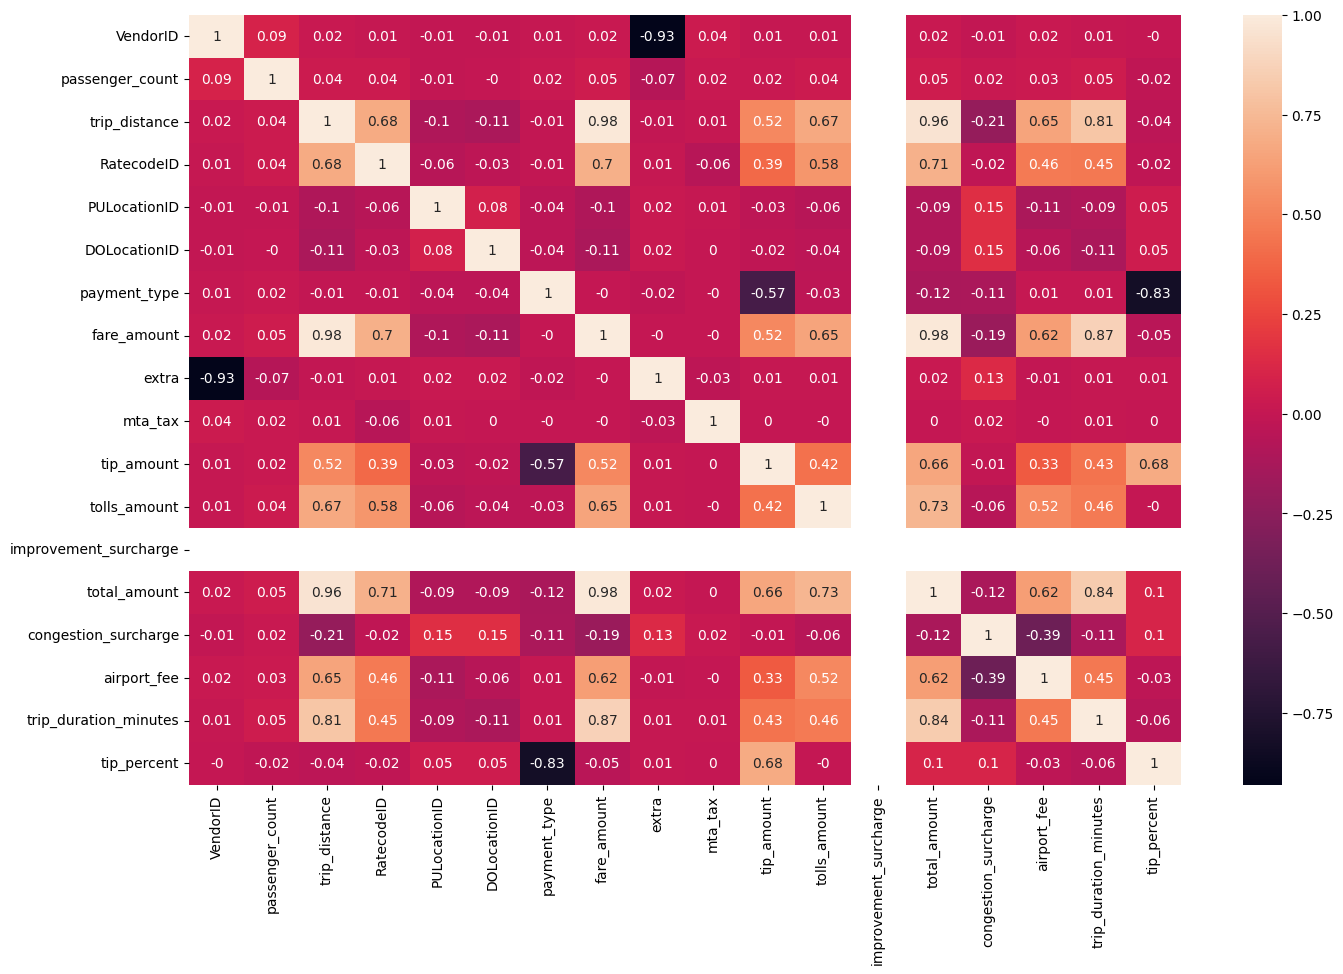

In [98]:
plt.figure(figsize = (16,10))
sns.heatmap(round(raw_df.corr(),2),annot=True)

#### Extra
Miscellaneous extras and surcharges. Currently, this only includes the $0.50 and $1 rush hour and overnight charges

In [99]:
raw_df['extra'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.995, 0.999])

count   101519.000
mean         0.848
std          1.205
min          0.000
10%          0.000
25%          0.000
50%          0.000
75%          2.500
90%          2.500
99%          3.500
99.5%        3.750
99.9%        4.500
max          9.000
Name: extra, dtype: float64

**Assumptions**:
- as it is miscellaneous charges, and i could not find information on internet i will assume it has impact on the duration of the trip and it *will be removed* from the dataset.

### removing columns to avoid data leakage

As trip duration will be our target variable, removing columns that could have not-direct relationship to trip duration and would cause data leakage:  
* fare amount: The time-and-distance fare calculated by the meter.
* tip amount: Tip amount – This field is automatically populated for credit card
* total_amount: The total amount charged to passengers. Does not include cash tips.
* Extra: Miscellaneous extras and surcharges. Currently, this only includes the $0.50 and $1 rush hour and overnight charges
* MTA tax: is applied equally to all rides
* improvement surcharge: is applied equally to all rides
* airport fee: in most of datasets this column holds only None values.
* congestion_surcharge: most of datasets this column holds only None values


In [100]:
raw_df.drop(['fare_amount','tip_amount','total_amount', 'extra', 'mta_tax', 'improvement_surcharge','tip_percent','airport_fee','congestion_surcharge'  ],axis=1,inplace=True)

C:\Users\G026361\AppData\Local\Temp\ipykernel_13040\427441234.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(round(raw_df.corr(),2),annot=True)


<Axes: >

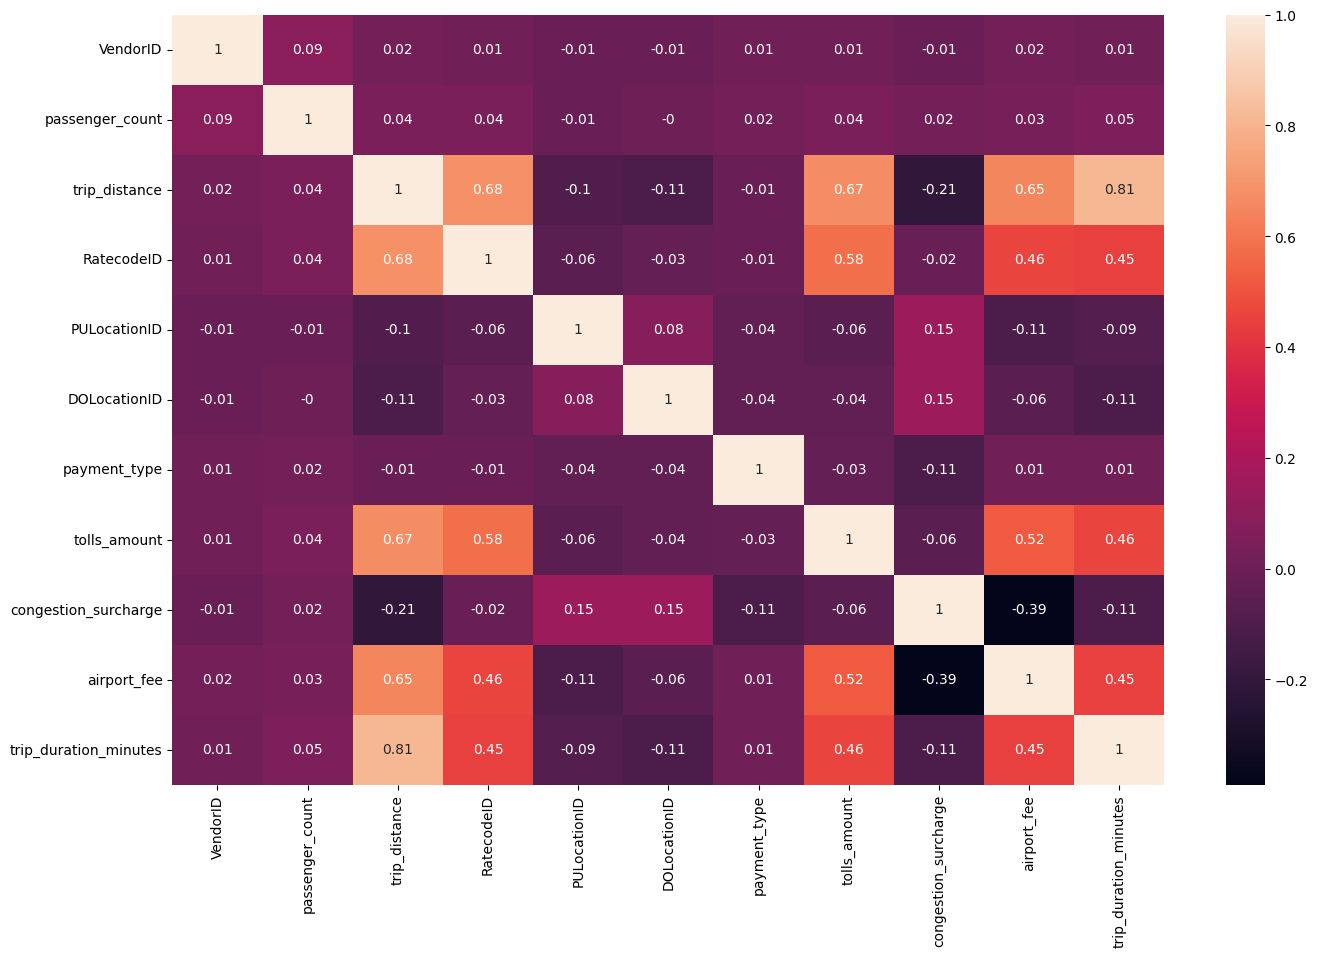

In [101]:
plt.figure(figsize = (16,10))
sns.heatmap(round(raw_df.corr(),2),annot=True)

### Feature Engineering
During feature engineering main purpose is to enrichen dataset with aggregated columns.

new features created:  
1. is_weekend : boolean column to identify if it is a weekend day (complete)
2. is_working_hours:
3. time_of_day:
4. weekday

Decided to exclude rush_hours as it is a christmas period (24th to 26th of December) from MVP as well as year number.

columns to be removed after feature engineering:
* customer pickup datetime
* custumer drop off datetime

In [102]:
clean_df = raw_df.copy()

In [103]:
# monday = 0, sunday =6

clean_df['is_weekend'] = clean_df['tpep_pickup_datetime'].dt.weekday >= 5

In [104]:
clean_df['weekday'] = clean_df['tpep_pickup_datetime'].dt.weekday
clean_df['weekday']= clean_df['weekday'].map({0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday', 6:'Sunday'})

In [105]:

clean_df['hour'] = clean_df['tpep_pickup_datetime'].dt.hour

In [106]:
def define_if_business_hours(value):
    if value >= 7 and value <=18:
        
        return True
    else:
        return False

# https://www.britannica.com/dictionary/eb/qa/parts-of-the-day-early-morning-late-morning-etc

def define_time_of_day(hour):
    if hour >= 5 and hour < 12:
        return 'Morning'
    if hour >=12 and hour <17:
        return 'Afternoon'
    if hour >= 17 and hour < 21:
        return 'Evening'
    if  0 <= hour < 5 or 21<= hour <25:
        return 'Night'
    

In [107]:
clean_df['is_business_hours'] = clean_df['hour'].apply(define_if_business_hours)

In [108]:
clean_df['time_of_day'] = clean_df['hour'].apply(define_time_of_day)

In [109]:
clean_df.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'hour'],axis=1,inplace=True)

C:\Users\G026361\AppData\Local\Temp\ipykernel_13040\952459641.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(round(clean_df.corr(),2),annot=True)


<Axes: >

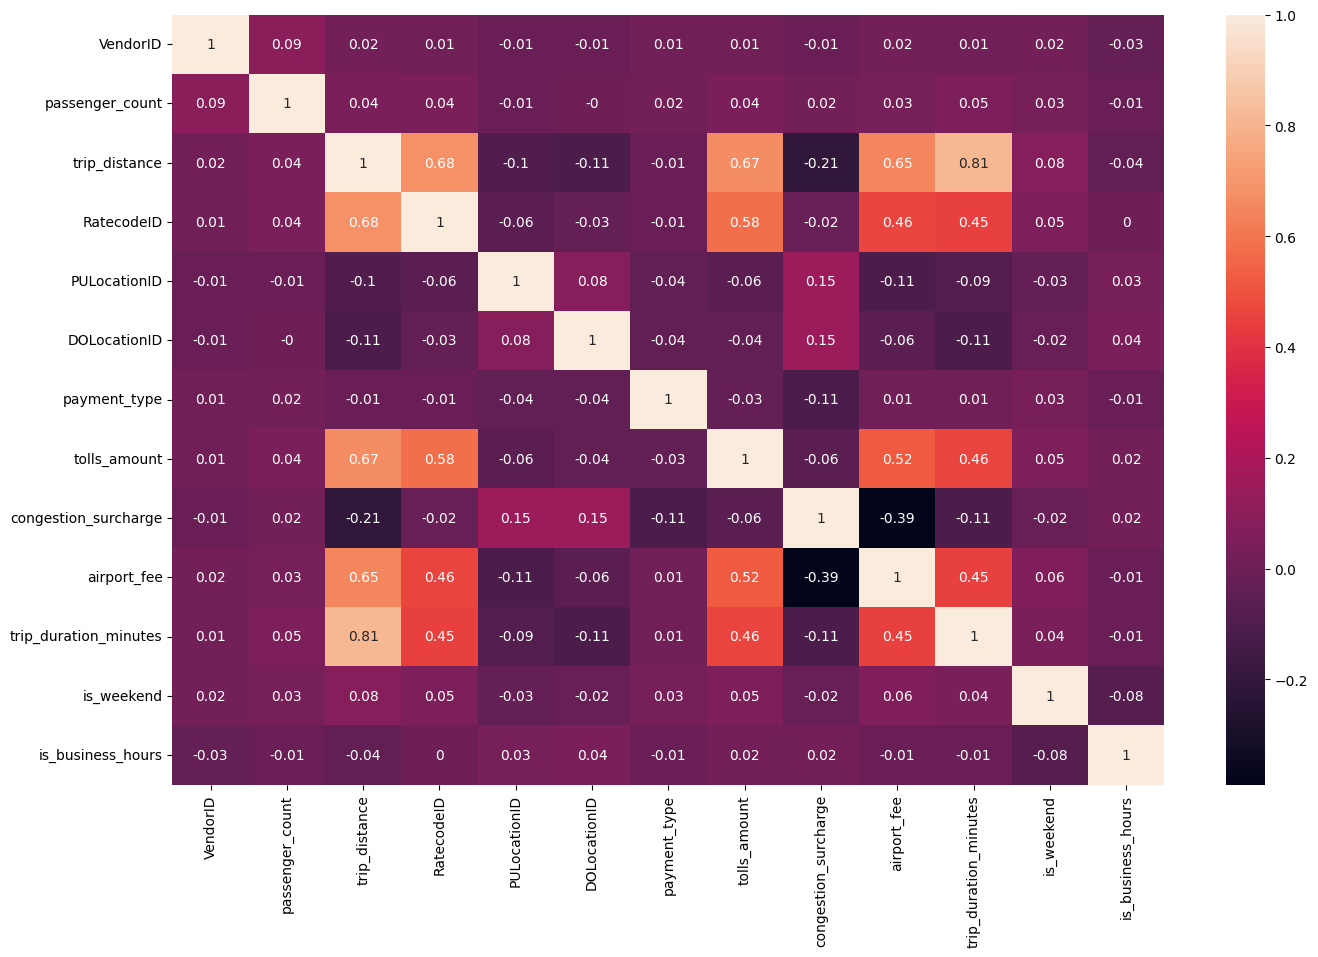

In [110]:
plt.figure(figsize = (16,10))
sns.heatmap(round(clean_df.corr(),2),annot=True)

In [116]:
# clean_df[['is_business_hours', 'hour','time_of_day']][:20]

In [117]:
# clean_df['hour'].value_counts()

In [118]:
# clean_df['minute'] = clean_df['tpep_pickup_datetime'].dt.minute

In [119]:
# clean_df['second'] = clean_df['tpep_pickup_datetime'].dt.second

In [120]:
# test = clean_df.groupby(['hour','minute']).count()['tpep_pickup_datetime'].reset_index(name='count')

In [121]:
# test

In [122]:
# median = dict(test.groupby('minute').median()['count'])
# average = dict(test.groupby('minute').mean()['count'])
# quantile = dict(test.groupby('minute').apply(lambda x: np.quantile(x['minute'],0.6) ))

In [123]:
# test['pickup_per_minute_median'] = test['minute'].map(median)
# test['pickup_per_minute_mean'] = test['hour'].map(average)
# test['pickup_per_minute_quantile'] = test['minute'].map(quantile)

In [124]:
# test['rush_time_median'] = test['count'] > test['pickup_per_minute_median']
# test['rush_time_mean'] = test['count'] > test['pickup_per_minute_mean']
# test['rush_time_quantile'] = test['count'] > test['pickup_per_minute_quantile']

In [125]:
# test[:50]

In [126]:
# test.rush_time_mean.value_counts()

In [127]:
# test.groupby('hour').sum()['rush_time_mean']

In [128]:
# import holidays

In [129]:
# holidays.CountryHoliday('US','NC').get(key='12-27')